<footer id="footer"></footer>

# <center> Спрос на рейсы авиакомпании </center>

<p align="center"><img src='https://i.ibb.co/VS9n8nH/shutterstock-1017473134.jpg'></p>

Для российской авиакомпании **F9**, выполняющей внутренние пассажирские перевозки необходимо понять предпочтения пользователей, покупающих билеты на разные направления.

Нам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.  


---
<font size="1">
Примечание

*Мы уже достали данные из базы данных, анализировать будем csv файлы-результаты* [*запросов*](https://colab.research.google.com/drive/1osBgCMLtOMNYpirrVkX_hSZhVLjdsAuJ#scrollTo=OU5rZlUzXR6f)
</font>     

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

In [ ]:
%%capture
!pip install geopandas

In [ ]:
%%capture
!pip install folium

In [ ]:
%%capture
!pip install geopy==1.22.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import math
import folium
import warnings


from folium import Marker
from folium.plugins import MarkerCluster
from geopandas.tools import geocode


warnings.filterwarnings("ignore")
sns.set_style ('darkgrid')
%matplotlib inline
np.random.seed(42)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

## Импорт данных

In [ ]:
%%capture
!gdown --id 1nI8fREutjBidCPIJIdRPDUrLTpUXBwa8
!gdown --id 1Y40Rzb36hMlpWJ2FtKdPanf1pR7s-PaU

In [ ]:
try:
    df_q1 = pd.read_csv('/content/query_1.csv')
    df_q3 = pd.read_csv('/content/query_3.csv')
except:
    df_q1 = pd.read_csv('/datasets/query_1.csv')
    df_q3 = pd.read_csv('/datasets/query_3.csv')

In [ ]:
def get_info(data):
    display(data.head().style.set_caption('Общая информация по датасету'))
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    display(data.info())
    print('----')
    print()

In [ ]:
get_info(df_q1)

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


,count,mean,std,min,25%,50%,75%,max
flights_amount,8.0,2035.625,1965.203947,300.0,605.25,795.0,4250.25,4557.0


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


None

----




**df_q1 - query_1.csv** — результат первого запроса. В нём содержится следующая информация:

- *model* — модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

Пропусков не наблюдается, преобразовать типы данных нет необходимости: для названий нас устраивает `object`,  

для количества устраивает `int64` - целые числа. Можно немного уменьшить занимаему память, понизив тип до `int16`


In [ ]:
df_q1 = df_q1.astype({'flights_amount': 'int16'})

In [ ]:
df_q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int16
dtypes: int16(1), object(1)
memory usage: 208.0+ bytes


Незначительно, сэкономили занимаемую память. Посмотрим второй сет

In [ ]:
get_info(df_q3)

,city,average_flights
0,Абакан,3.87097
1,Анадырь,1
2,Анапа,2.16129
3,Архангельск,5.35484
4,Астрахань,2.45161


,count,mean,std,min,25%,50%,75%,max
average_flights,101.0,5.494189,13.11979,1.0,2.0,3.0,5.870968,129.774194


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


None

----



**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

Пропусков не наблюдается, преобразовать типы данных нет необходимости: для названий нас устраивает `object`, для среднего количества перелетов устраивает `float64` - дробные числа. Здесь менять тип данных не будем - занимаемоме место - незначительно

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

## Модели самолётов и количество рейсов

In [ ]:
(df_q1.sort_values(by='flights_amount', ascending=False)
 .reset_index(drop=True).style.set_caption('Данные по количеству совершенных '
                                            'полетов каждой модели самолета')
 .set_precision(2).background_gradient(low=0.42)).hide_index()

model,flights_amount
Cessna 208 Caravan,4557
Bombardier CRJ-200,4446
Sukhoi SuperJet-100,4185
Airbus A321-200,960
Boeing 737-300,630
Airbus A319-100,607
Boeing 767-300,600
Boeing 777-300,300


Лидирующие позиции занимают самолеты [Cessna 208 Caravan](https://ru.wikipedia.org/wiki/Cessna_208), [Bombardier CRJ-200](https://ru.wikipedia.org/wiki/Bombardier_CRJ200), [Sukhoi SuperJet-100](https://ru.wikipedia.org/wiki/Sukhoi_Superjet_100). Стоит отметить, что для своих более вместительных соседей по рейтингу - Cessna может перевозить только до 13 пассажиров, вероятнее всего, чаще будет использовать в регионах. В будущем можно провести анализ по распределению самолетов по регионам

In [ ]:
top_planes = (df_q1.sort_values(by='flights_amount', ascending=False)
             .reset_index(drop=True))
top_planes

,model,flights_amount
0,Cessna 208 Caravan,4557
1,Bombardier CRJ-200,4446
2,Sukhoi SuperJet-100,4185
3,Airbus A321-200,960
4,Boeing 737-300,630
5,Airbus A319-100,607
6,Boeing 767-300,600
7,Boeing 777-300,300


Визуализируем получившийся лидерборд самолетов

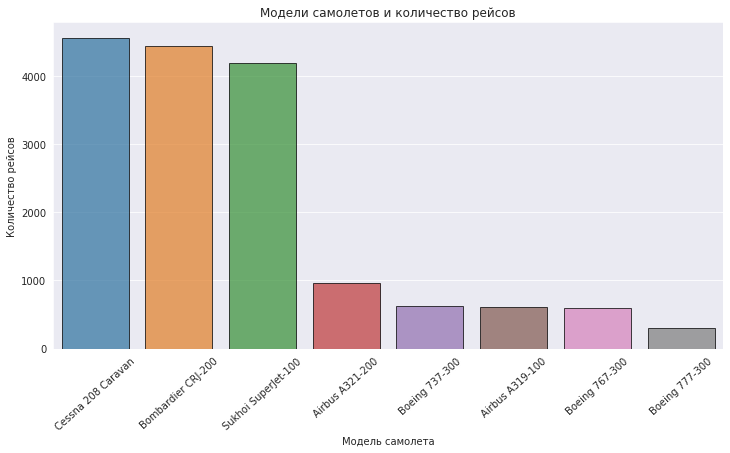

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=42)
plt.title("Модели самолетов и количество рейсов")
ax_1 = sns.barplot(x=top_planes['model'], y=top_planes['flights_amount'], 
            alpha=.72, data=top_planes, dodge=True)

for patch in ax_1.patches:
    patch.set_edgecolor('black')

plt.ylabel("Количество рейсов")
plt.xlabel("Модель самолета")
plt.show()

Таким образом в авиапарке РФ лидирующие позиции занимают три самолета - [Cessna 208 Caravan](https://ru.wikipedia.org/wiki/Cessna_208), [Bombardier CRJ-200](https://ru.wikipedia.org/wiki/Bombardier_CRJ200), [Sukhoi SuperJet-100](https://ru.wikipedia.org/wiki/Sukhoi_Superjet_100)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

## Топ-10 городов по количеству рейсов

In [ ]:
top_10_cities = df_q3.sort_values(by='average_flights', ascending=False).head(10)
top_10_cities.style.hide_index()

city,average_flights
Москва,129.774
Санкт-Петербург,31.1613
Новосибирск,17.3226
Красноярск,11.5806
Екатеринбург,11.3226
Ростов-на-Дону,10.1935
Пермь,10.129
Брянск,10
Сочи,9.6129
Ульяновск,9.58065


In [ ]:
(top_10_cities.style.set_caption('Данные по среднему количеству принятых '
                                            'авиарейсов')
 .set_precision(4).background_gradient(low=0.08)).hide_index()

city,average_flights
Москва,129.8
Санкт-Петербург,31.16
Новосибирск,17.32
Красноярск,11.58
Екатеринбург,11.32
Ростов-на-Дону,10.19
Пермь,10.13
Брянск,10
Сочи,9.613
Ульяновск,9.581


Абсолютный лидер - Москва

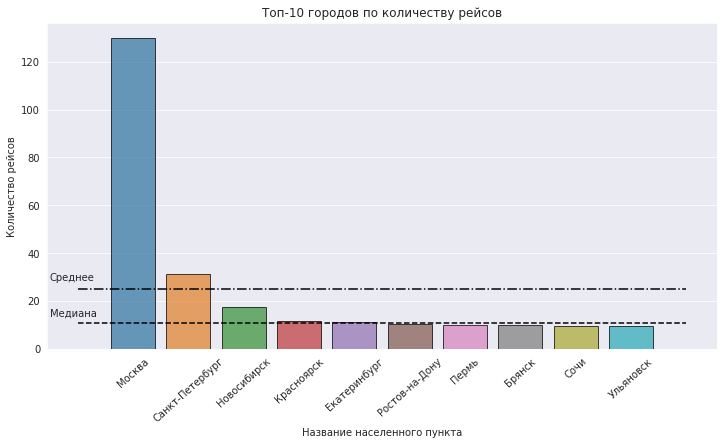

In [ ]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=42)
plt.title("Топ-10 городов по количеству рейсов")
ax_2 = sns.barplot(x=top_10_cities['city'], y=top_10_cities['average_flights'], 
            alpha=.72, data=top_10_cities)
for patch in ax_2.patches:
    patch.set_edgecolor('black')
    
median_top = top_10_cities['average_flights'].median()
mean_top = top_10_cities['average_flights'].mean()
plt.hlines(y=median_top, xmin=-1, xmax=10, linestyle='--')
plt.text(-1.5, 15, 'Медиана', ha='left', va='center')
plt.hlines(y=mean_top, xmin=-1, xmax=10, linestyle='dashdot', label='Mean')
plt.text(-1.5, 30, 'Среднее', ha='left', va='center')
plt.ylabel("Количество рейсов")
plt.xlabel("Название населенного пункта")
plt.show()

Лидерство принадлежит Москвае, затем следует Санкт-Петербург, остальные 8 городов имеют более менее близкие друг к другу и медиане значения загруженности по прилетам в день, при этом значения Москвы по своей сути являются выбросом по отношению к остальным значениям выборки


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

## Города и количество рейсов

In [ ]:
unique = df_q3['city'].nunique()
print(f'Количество уникальных городов: {unique}')

Количество уникальных городов: 101


Строить гистограмму для такого количества городов будет громоздко - реализуем визуализацию через библиотеку `folium`

In [ ]:
df_q3.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


Для начала нам необходимо провести геокодинг и для названия городов получить координаты. Воспользуемся geocode и [Nominatim](https://nominatim.openstreetmap.org/ui/search.html) как провайдер координат

In [ ]:
def geocoder(row):
    try:
        point = geocode(row, provider='nominatim').geometry.iloc[0]
        return pd.Series({'Latitude': point.y, 'Longitude': point.x, 'geometry': point})
    except:
        return None

In [ ]:
df_q3[['Latitude', 'Longitude', 'geometry']] = df_q3.apply(lambda x: geocoder(x['city']), axis=1)

In [ ]:
df_q3.drop([62, 89], axis=0, inplace=True)

In [ ]:
df_q3.head()

,city,average_flights,Latitude,Longitude,geometry
0,Абакан,3.870968,53.720650,91.440355,POINT (91.44035529999999 53.7206497)
1,Анадырь,1.000000,64.731688,177.506092,POINT (177.5060925 64.73168750000001)
2,Анапа,2.161290,44.894272,37.316887,POINT (37.316887 44.894272)
3,Архангельск,5.354839,64.585487,40.532142,POINT (40.53214165232831 64.58548709999999)
4,Астрахань,2.451613,46.349831,48.032620,POINT (48.0326203 46.3498308)


Проверим, все ли города получили свой геокод

In [ ]:
print("{}% городов были геокодированы!".format(
    (1 - sum(np.isnan(df_q3["Latitude"])) / len(df_q3)) * 100))

100.0% городов были геокодированы!


Поставим заглушку, на случай, если при перезапуске блокнота будет сбой в получении координат

In [ ]:
df_q3.loc[np.isnan(df_q3["Latitude"])]

,city,average_flights,Latitude,Longitude,geometry


In [ ]:
df_q3 = df_q3.loc[~np.isnan(df_q3["Latitude"])]

Создадим геопандас датафрейм и отобразим наши города с количеством перелетов на карте

In [ ]:
cities = gpd.GeoDataFrame(df_q3, geometry=df_q3.geometry)
cities.crs = {'init': 'epsg:4326'}
cities.head()

,city,average_flights,Latitude,Longitude,geometry
0,Абакан,3.870968,53.720650,91.440355,POINT (91.44036 53.72065)
1,Анадырь,1.000000,64.731688,177.506092,POINT (177.50609 64.73169)
2,Анапа,2.161290,44.894272,37.316887,POINT (37.31689 44.89427)
3,Архангельск,5.354839,64.585487,40.532142,POINT (40.53214 64.58549)
4,Астрахань,2.451613,46.349831,48.032620,POINT (48.03262 46.34983)


In [ ]:
m = folium.Map(location=[54, 85], tiles='openstreetmap', zoom_start=2)

mc = MarkerCluster()
for idx, row in cities.iterrows(): 
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker(location=[row['Latitude'], row['Longitude']],
                            tooltip=[round(row['average_flights'], 2), row['city']]))
    
m.add_child(mc)    
m

Наиболее загруженные округа - Центральный округ, Южный, Уральский, Сибирский центральный округ

Рекомендуется добавить дополнительно точку вылета - это позволит проаназировать наиболее загруженные направления, и с учетом анализа использумых бортов - можно сделать выводы о необходимости или ее отсутствия для переброса дополнительных более вместительных бортов на то или иное направление

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>

---

## Вывод

1. Из [БД](https://colab.research.google.com/drive/1osBgCMLtOMNYpirrVkX_hSZhVLjdsAuJ) извлекли корректные данные - типы данных не требуют преобразования, пропусков нет  
2. Лидирующие позиции по перевозкам занимают самолеты моделей **Cessna 208 Caravan, Bombardier CRJ-200, Sukhoi SuperJet-100**.
3. **Москва и Санкт-Петербург** - самые загруженные направления для авиаперевозок, тем более в период фестивалей. При этом также стоит отметить, что в совокупности - наиболее загруженные **Центральный округ, Южный, Уральский, Сибирский центральный округ**


Также рекомендую провести исследования:
- по количеству бортов в различных регионах;  
- добавить в анализ точки вылета и прилета - что позволит проанализировать наиболее загруженные направления авиаперевозок, а не только города-гавани;  
- добавить в анализ дополнительную выборку вне времени проведения фестивалей, для проверки статистических гипотез о равенстве двух совокупностей